In [1]:
import ee
import numpy as np

ee.Authenticate()
ee.Initialize()





To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=jxHr5SG_4OJwLyG-IwVqc2vtPfreI_wBUTLrf4_pfd0&tc=DOOahJnITUShO3INkFwiOVSQRZJ9XgMgdYyRYUpDnBE&cc=FUJBu_oejsFGDf3AiidhNTsN8U0st3OP4j4uY0lIs8s

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VNGAz-gRc4jesqTEHt91rjJGJGRCcrUzrKFIFU09qTC10o2-PxgcIk

Successfully saved authorization token.


In [26]:
# Define the region of interest
roi = ee.Geometry.Rectangle([77.929262, 30.194963, 78.147071, 30.376998])

# Define the time range for the image collection
start_date = '2021-01-01'
end_date = '2021-12-31'

In [27]:

landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
          .filterBounds(roi) \
          .filterDate(start_date, end_date) \
          .sort('CLOUD_COVER') \
          .first()

# Load the image collection for Sentinel-2 surface reflectance
sentinel = ee.ImageCollection('COPERNICUS/S2_SR') \
           .filterBounds(roi) \
           .filterDate(start_date, end_date) \
           .sort('CLOUDY_PIXEL_PERCENTAGE') \
           .first()

In [28]:
# Calculate Normalized Difference Water Index (NDWI)
dwi = sentinel.normalizedDifference(['B3', 'B8']).rename('ndwi')

# Calculate Dissolved Oxygen
do = sentinel.expression('(-0.0167*B8A+0.0067*B9+0.0083*B11+9.577)+10', 
                         {'B8A': sentinel.select('B8A'), 'B9': sentinel.select('B9'), 'B11': sentinel.select('B11')}).rename('DO')

# Calculate Salinity
salinity = sentinel.expression('((B11-B12) / (B11 + B12))+1', 
                               {'B11': sentinel.select('B11'), 'B12': sentinel.select('B12')}).rename('Salinity')

# Calculate Temperature
temp = landsat.expression('(B11*0.00341802+149.0-273.15)+133', 
                          {'B11': landsat.select('B11')}).rename('Temperature')

# Calculate pH
ph = sentinel.expression('8.339-0.827*(B1/B8)', 
                          {'B1': sentinel.select('B1'), 'B8': sentinel.select('B8')}).rename('pH')

# Calculate Turbidity
turbidity = sentinel.expression('((B4 - B3) / (B4 + B3))+0.1', 
                                 {'B3': sentinel.select('B3'),  'B4': sentinel.select('B4')}).rename('Turbidity')

# Calculate Dissolved Organic Matter
dom = sentinel.expression('((B7 * B5) / B3)/9', 
                           {'B7': sentinel.select('B7'), 'B5': sentinel.select('B5'), 'B3': sentinel.select('B3')}).rename('Dissolved_Organic_Matter')

# Calculate Suspended Matter
sm = sentinel.expression('((B3 * B5) / B8)*4', 
                          {'B3': sentinel.select('B3'), 'B5': sentinel.select('B5'), 'B8': sentinel.select('B8')}).rename('Suspended_Matter')

# Calculate Chlorophyll
chlorophyll = sentinel.expression('((B5-B4)/(B5+B4))-0.5', 
                                   {'B4': sentinel.select('B4'), 'B5': sentinel.select('B5')}).rename('Chlorophyll')

In [29]:
latlon = ee.Image.pixelLonLat() \
         .addBands(ph) \
         .addBands(do) \
         .addBands(salinity) \
         .addBands(temp) \
         .addBands(turbidity) \
         .addBands(dom) \
         .addBands(sm) \
         .addBands(chlorophyll) \
         .addBands(dwi) 
          
        

In [30]:
data = latlon.reduceRegion(reducer=ee.Reducer.first(), geometry=roi, scale=30).toArray()

In [31]:
latlon = ee.Image.pixelLonLat().addBands(ph).addBands(do).addBands(salinity).addBands(temp).addBands(turbidity).addBands(dom).addBands(sm).addBands(chlorophyll)


latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=roi,
  scale=100);

data_ph = np.array((ee.Array(latlon.get("pH")).getInfo()))
data_salinity = np.array((ee.Array(latlon.get("Salinity")).getInfo()))
data_do = np.array((ee.Array(latlon.get("DO")).getInfo()))
data_temp = np.array((ee.Array(latlon.get("Temperature")).getInfo()))
data_turbidity = np.array((ee.Array(latlon.get("Turbidity")).getInfo()))
data_dom = np.array((ee.Array(latlon.get("Dissolved_Organic_Matter")).getInfo()))
data_sm = np.array((ee.Array(latlon.get("Suspended_Matter")).getInfo()))
data_chlorophyll = np.array((ee.Array(latlon.get("Chlorophyll")).getInfo()))

In [32]:
import pandas as pd
df = pd.concat([pd.DataFrame(data_ph, columns=['pH']),
                pd.DataFrame(data_salinity, columns=['Salinity']),
                pd.DataFrame(data_do, columns=['Dissolved_Oxygen']),
                pd.DataFrame(data_temp, columns=['Temperature']),
                pd.DataFrame(data_turbidity, columns=['Turbidity']),
                pd.DataFrame(data_dom, columns=['Dissolved_Organic_Matter']),
                pd.DataFrame(data_sm, columns=['Suspended_Matter']),
                pd.DataFrame(data_chlorophyll, columns=['Chlorophyll'])], 
                axis=1)

# Save the dataset as a CSV file
df.to_csv('water_quality_data1.csv', index=False)

In [33]:
df.head()

,pH,Salinity,Dissolved_Oxygen,Temperature,Turbidity,Dissolved_Organic_Matter,Suspended_Matter,Chlorophyll
0,8.256581,1.307804,10.3111,18.820364,0.054151,357.311737,586.737976,-0.200000
1,8.265224,1.315706,8.1113,18.813528,0.017614,361.328674,466.336700,-0.172216
2,8.271290,1.348837,7.9296,18.799856,-0.027389,355.900818,385.328918,-0.145465
3,8.281897,1.376302,7.3713,18.786184,-0.093676,348.139069,283.480438,-0.091304
4,8.280197,1.362225,8.8081,18.782766,-0.084158,336.939423,294.325775,-0.093660


In [34]:

df = pd.read_csv('water_quality_data1.csv')

# Drop all rows containing null values
df = df.dropna()

# Save the cleaned data to a new CSV file
df.to_csv('cleaned_water_quality_data1.csv', index=False)

In [35]:

## find dublicate rows in dataset
duplicate = df[df.duplicated()]
duplicate

,pH,Salinity,Dissolved_Oxygen,Temperature,Turbidity,Dissolved_Organic_Matter,Suspended_Matter,Chlorophyll


In [36]:
for i in df.columns:
    print(f" {i}  :  {len(df[i].unique())}")

 pH  :  44215
 Salinity  :  42333
 Dissolved_Oxygen  :  46976
 Temperature  :  94
 Turbidity  :  31779
 Dissolved_Organic_Matter  :  48949
 Suspended_Matter  :  49200
 Chlorophyll  :  36303


In [37]:
df = pd.read_csv('cleaned_water_quality_data1.csv')

df.isnull().sum()

pH                          0
Salinity                    0
Dissolved_Oxygen            0
Temperature                 0
Turbidity                   0
Dissolved_Organic_Matter    0
Suspended_Matter            0
Chlorophyll                 0
dtype: int64

In [38]:
import matplotlib.pyplot as plt

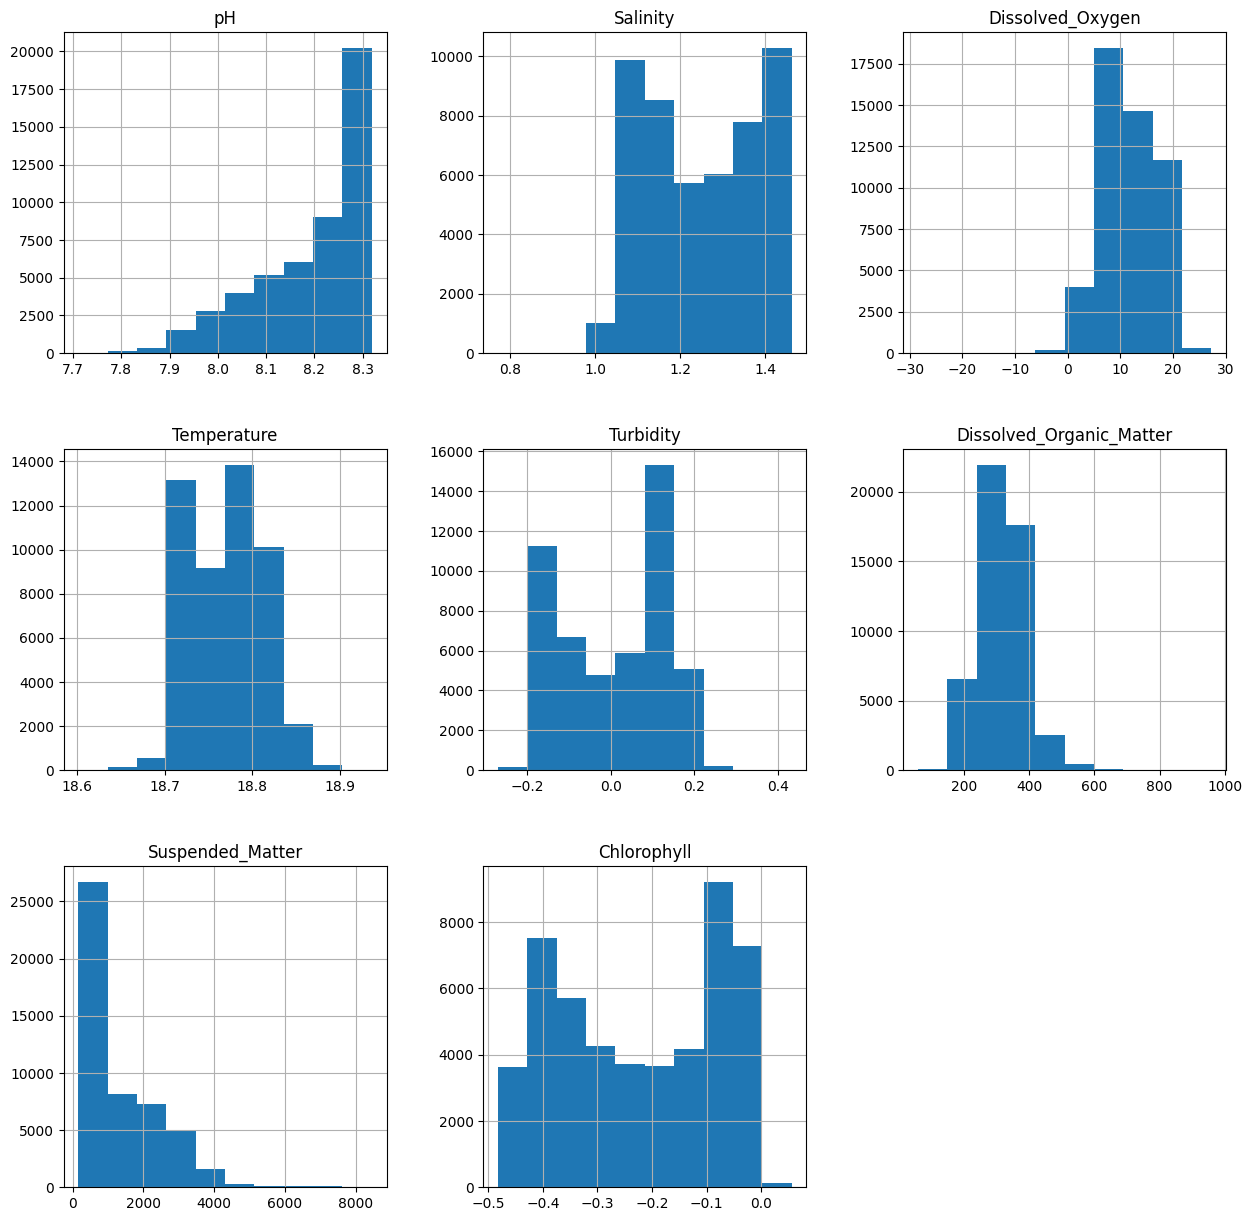

In [39]:
df.hist(figsize=(15,15))
plt.show()

In [40]:
# removing outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

pH                             0.162427
Salinity                       0.252561
Dissolved_Oxygen               8.878500
Temperature                    0.068360
Turbidity                      0.251784
Dissolved_Organic_Matter      89.677734
Suspended_Matter            1723.491669
Chlorophyll                    0.290788
dtype: float64


In [41]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

(47936, 8)

In [42]:
import seaborn as sns

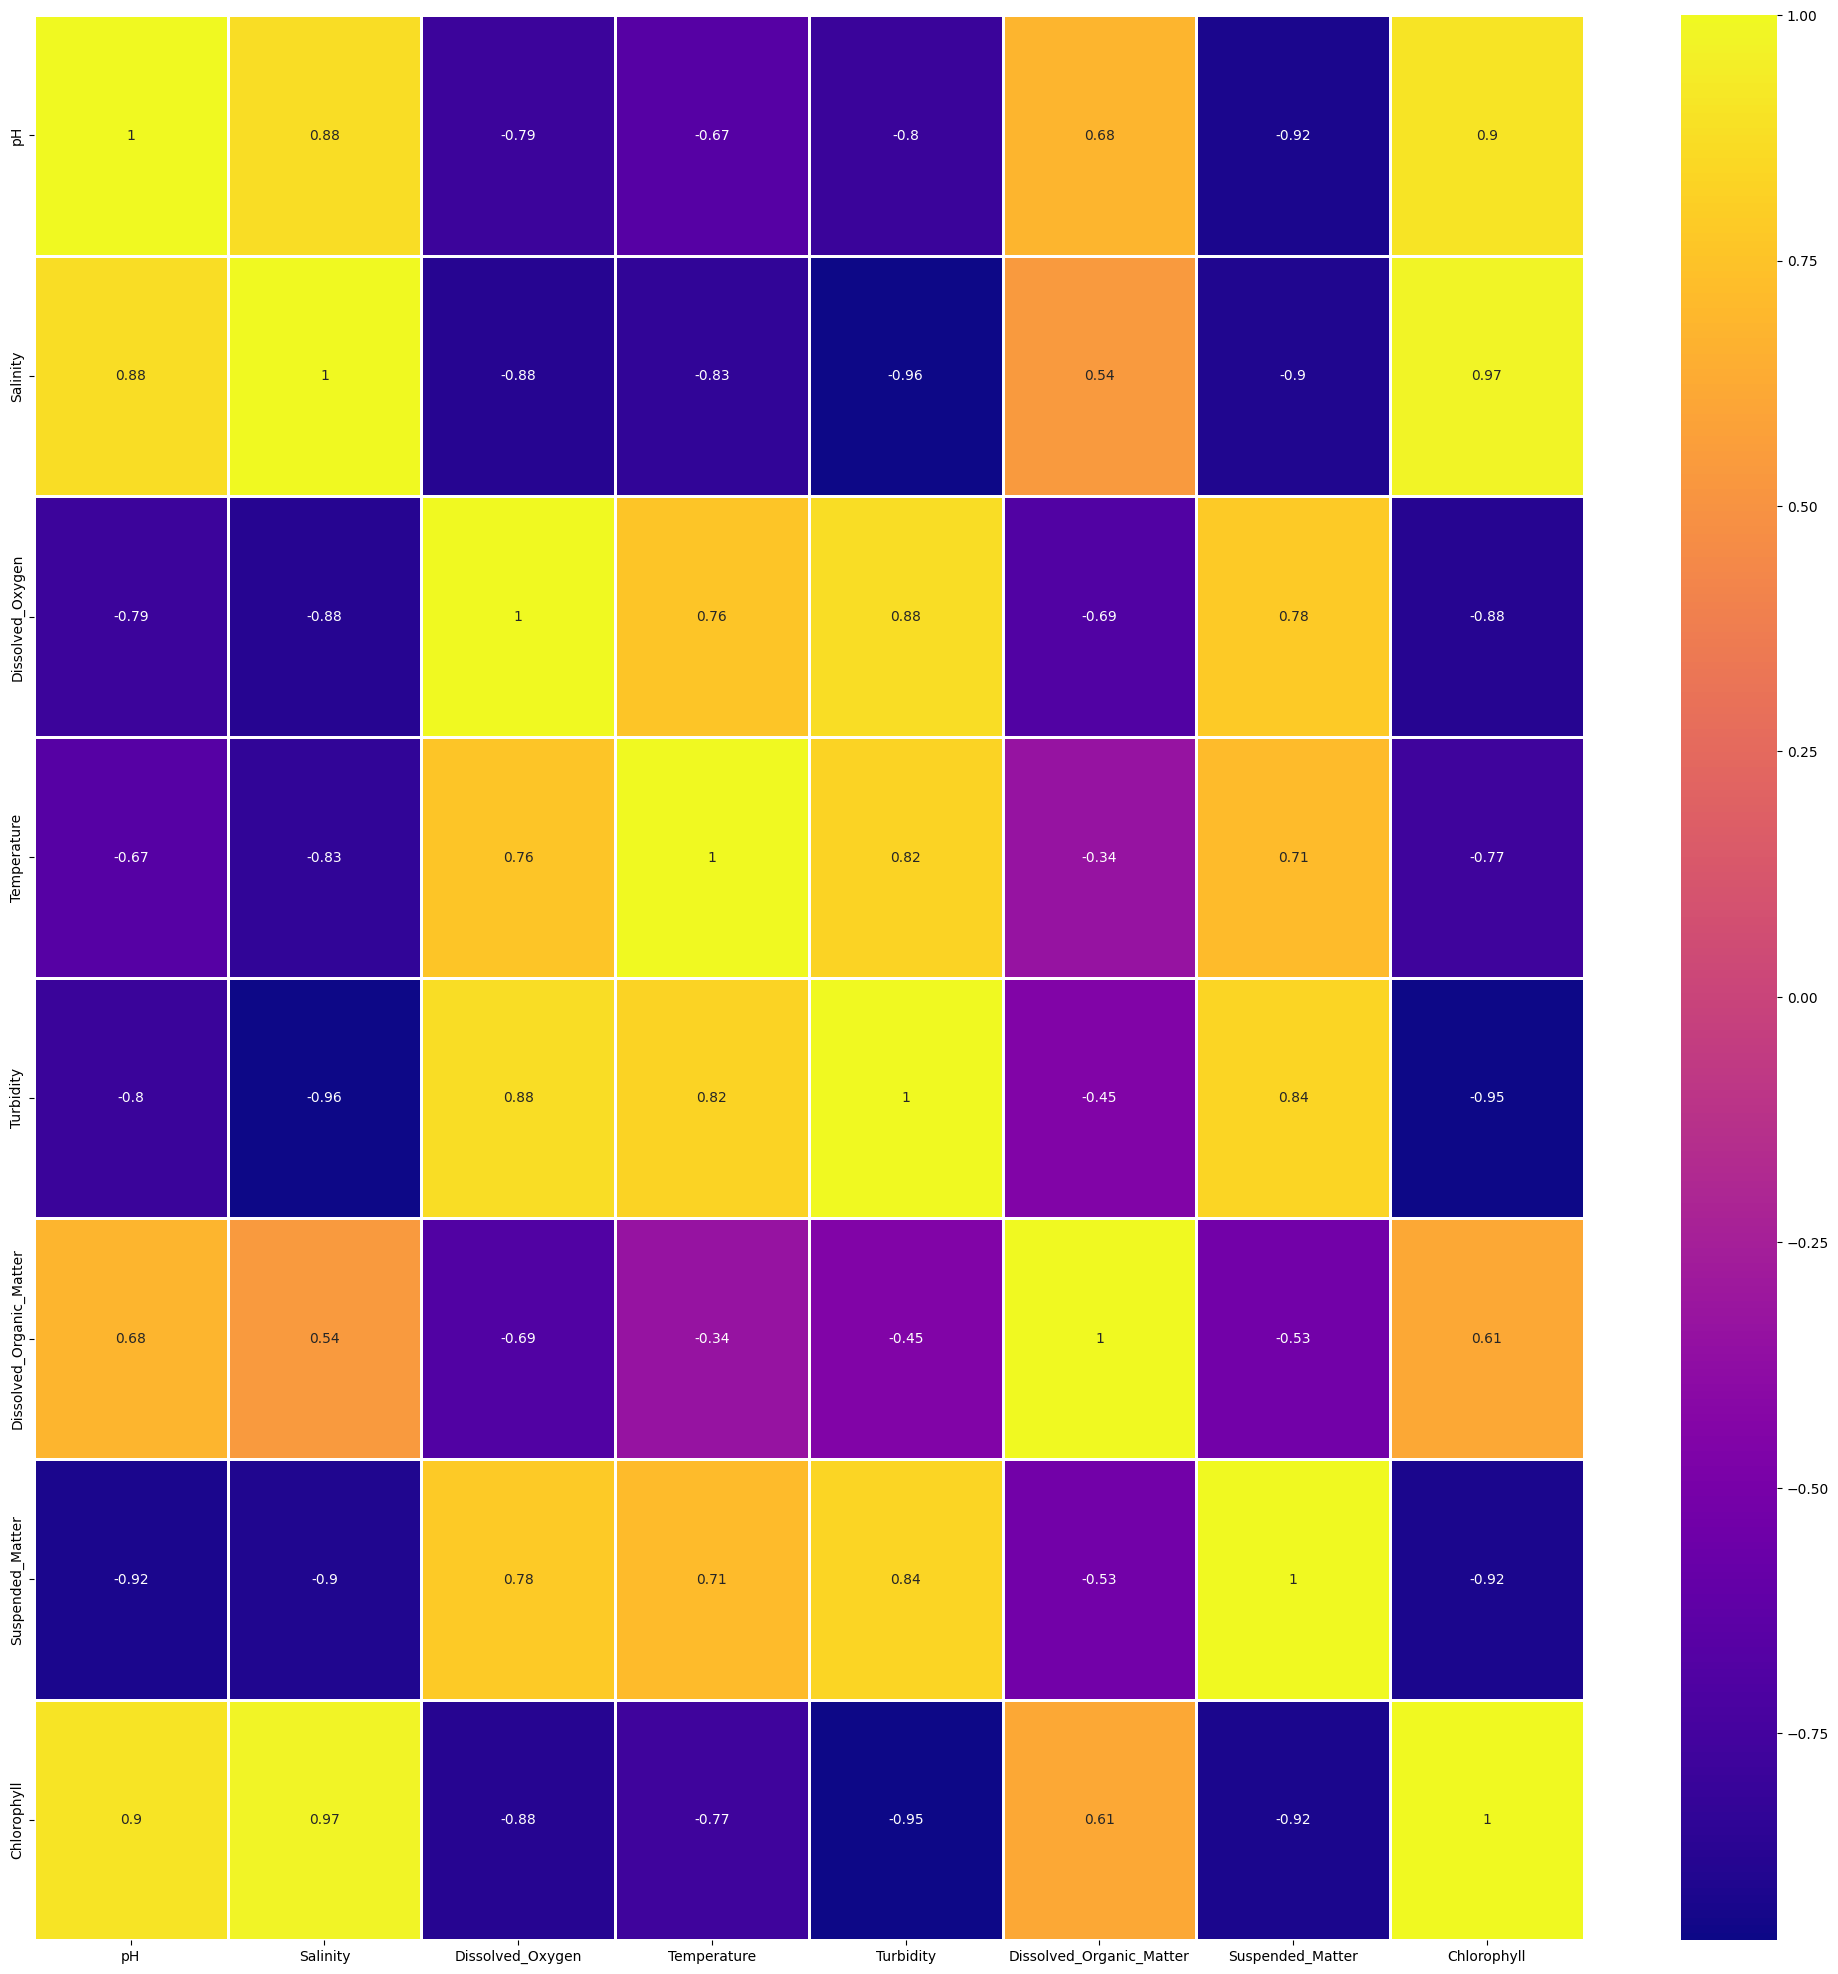

In [43]:
plt.figure(figsize=(25,25))
ax = sns.heatmap(df.corr(), cmap = "plasma", annot=True, linewidth=2)

In [44]:
def label_water_quality(row):
    if 6.5 <= row['pH'] <= 8.5 and row['Salinity'] > 1 and -0.2 <= row['Turbidity'] <= 0 and 15 <= row['Temperature'] <= 35 and -0.1 <= row['Chlorophyll'] <= 0.1 and 300 <= row['Suspended_Matter'] <= 600 and row['Dissolved_Organic_Matter'] < 500 and row['Dissolved_Oxygen'] > 6.5:
        return 1
    else: 
        return 0
   
# Apply the function to create a new column "Water Quality"
df['Water Quality'] = df.apply(lambda row: label_water_quality(row), axis=1)

# Save the labeled dataset as a CSV file
df.to_csv('labeled_water_quality_data.csv', index=False)

In [45]:
df["Water Quality"].value_counts()

0    44490
1     3446
Name: Water Quality, dtype: int64

In [46]:
### splitting data into x and y
X = df.iloc[: , : -2 ]
y = df.iloc[ : , -1]

In [47]:
# split dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 5)

In [48]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_final = sc.fit_transform(X_train)
X_test_final = sc.transform(X_test)

In [49]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [50]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 30, criterion = 'entropy', class_weight = "balanced_subsample",random_state = 51)
rf_classifier.fit(X_train_final, y_train)
y_pred = rf_classifier.predict(X_test_final)
accuracy_score(y_test, y_pred)

0.9854669355399486

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     13376
           1       0.92      0.87      0.89      1005

    accuracy                           0.99     14381
   macro avg       0.95      0.93      0.94     14381
weighted avg       0.99      0.99      0.99     14381



In [53]:
from sklearn.svm import SVC
svc_classifier = SVC(class_weight = "balanced" )
svc_classifier.fit(X_train_final, y_train)
y_pred_svc = svc_classifier.predict(X_test_final)
accuracy_score(y_test, y_pred_svc)

0.9036228356859746

In [58]:
input_data = (8.1,1.01,8.4,18.2,0.01,350.8,300.45)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = svc_classifier.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 0):
  print('The water is not safe')
else:
  print('The wate is safe')

[0]
The water is not safe


In [59]:
import pickle

In [60]:
filename = 'trained_model.sav'
pickle.dump(svc_classifier, open(filename, 'wb'))